In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam# Preparing The Data

In [2]:
!pipreqs

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in /Users/abhinavgorukanti/computer_vision/requirements.txt


# Splitting Data 70% train, 15% validation, 15% testing

In [2]:

"""
pip install split-folders
"""

import splitfolders  # or import split_folders

input_folder = 'basedata/Natural_and_Spam'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
splitfolders.ratio(input_folder, output='basedata/Natural_and_Spam_SPLITTED', 
                   seed=42, ratio=(.7, .15, .15), 
                   group_prefix=None) # default values


# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# # enable oversampling of imbalanced datasets, works only with fixed
# splitfolders.fixed(input_folder, output="cell_images2", 
#                  # Preparing The Data  seed=42, fixed=(35, 20), 
#                    oversample=False, group_prefix=None) 


Copying files: 1739 files [00:00, 2509.19 files/s]


# Preparing The Data

In [3]:
import pathlib
data_dir = 'basedata/Natural_and_Spam'
data_dir = pathlib.Path(data_dir)
print(data_dir)

basedata/Natural_and_Spam


basedata/Natural_and_Spam/NaturalImages/zzz_407666284_6ebd1325fc_m.jpg


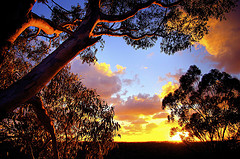

In [4]:
roses = list(data_dir.glob('NaturalImages/*'))
print(roses[0])
PIL.Image.open(str(roses[0]))

In [5]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'basedata/Natural_and_Spam_SPLITTED/train',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1217 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'basedata/Natural_and_Spam_SPLITTED/val',
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 260 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['NaturalImages', 'SpamImages']


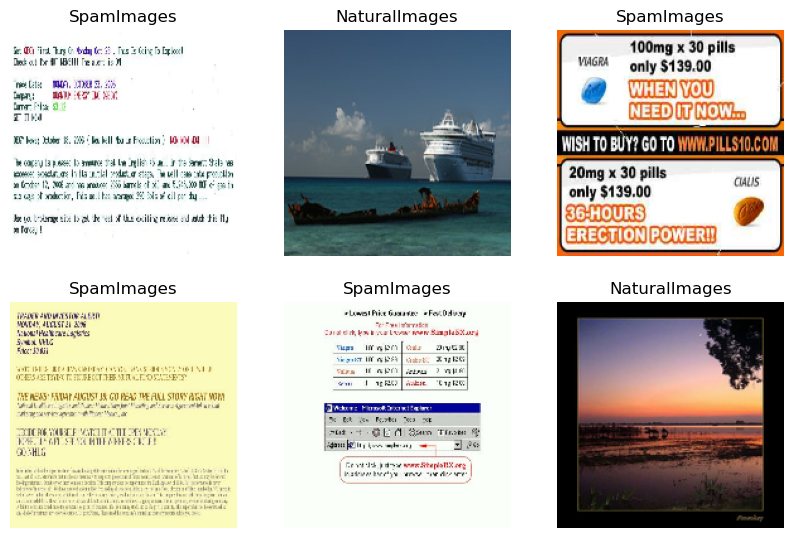

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model

In [9]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 2)                 1026      
 apper)                                                          
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
__________

In [11]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [13]:
epochs=1
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

39/39 [==============================] - 20s 504ms/step - loss: 0.1610 - accuracy: 0.9762 - val_loss: 0.0395 - val_accuracy: 0.9885


# Evaluating The Model

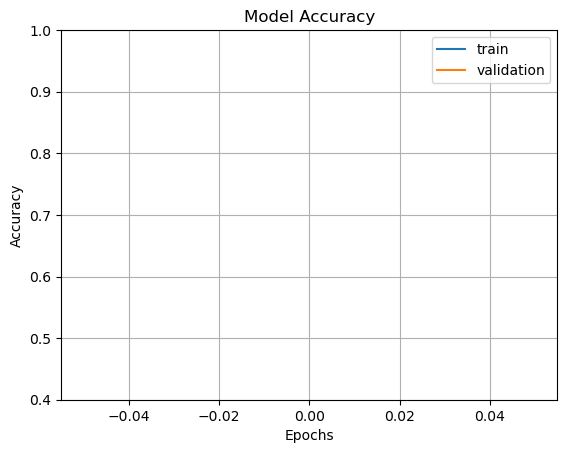

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

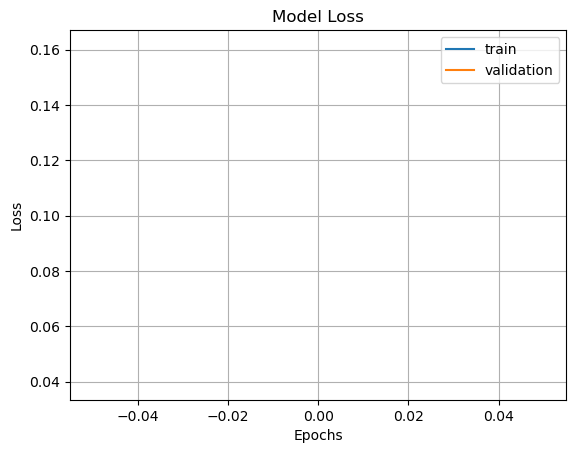

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

basedata/Natural_and_Spam/NaturalImages/zzz_20596_81931be621_m.jpg
(1, 180, 180, 3)


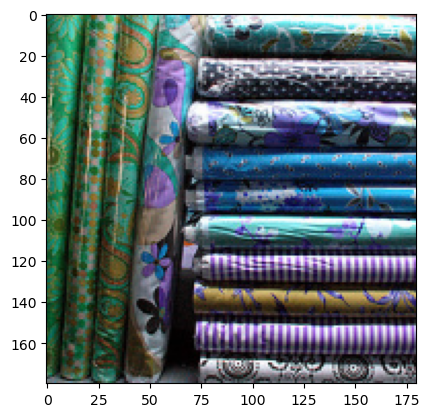

In [16]:
import cv2
image=cv2.imread(str(roses[1]))

print(str(roses[1]))
image_resized= cv2.resize(image, (img_height,img_width))
#print(image_resized)
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
plt.imshow(image_resized)

In [17]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 457ms/step
[[0.7668824 0.2331176]]


In [18]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is NaturalImages


In [28]:
from tensorflow.keras.preprocessing import image

dir_path = 'basedata/Natural_and_Spam_SPLITTED/'
#count = 0
files_list = []
for root, dirs, files in os.walk(dir_path):
    
#     for directory in dirs:
#          print("Subdirectory:", os.path.join(root, directory))
    
    for file in files:
        imgFile = os.path.join(root, file)
        files_list.append(file)
        #img = image.load_img(imgFile, target_size=(180,180))
            
        #X= cv2.resize(image, (img_height,img_width))
        #plt.imshow(img)
        #plt.show()
#print(files_list)
def print_duplicates(my_list):
    seen = set()
    dupes = []
    for item in my_list:
        if item in seen:
            dupes.append(item)
        else:
            seen.add(item)
    if dupes:
        print("Duplicate strings:", ", ".join(dupes))
    else:
        print("No duplicate strings found.")
print_duplicates(files_list)

Duplicate strings: .DS_Store, .DS_Store


1/1 [==============================] - 0s 42ms/step
Image detected wrong at 82


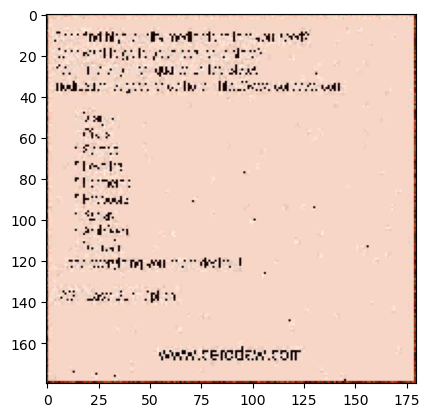

1/1 [==============================] - 0s 44ms/step
Image detected wrong at 178


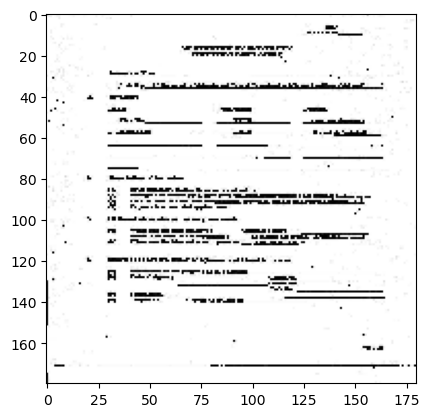

1/1 [==============================] - 0s 43ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [19]:
from tensorflow.keras.preprocessing import image

dir_path = 'basedata/Natural_and_Spam_SPLITTED/test'
#count = 0
predictions = []
actual = []
rounded = 0
index = 0
for root, dirs, files in os.walk(dir_path):
    
#     for directory in dirs:
#          print("Subdirectory:", os.path.join(root, directory))
    
    for file in files:
        imgFile = os.path.join(root, file)
        if(root == "basedata/Natural_and_Spam_SPLITTED/test/SpamImages"):
            actual.append(1)
        else:
            actual.append(0)
        img = image.load_img(imgFile, target_size=(180,180))
            
        #X= cv2.resize(image, (img_height,img_width))
        #plt.imshow(img)
        #plt.show()

        X = image.img_to_array(img)
        X = np.expand_dims(X,axis=0)
        images = np.vstack([X])
        val = resnet_model.predict(images)
        if(val[0][0]>.5):
            rounded = 0
        else:
            rounded = 1
        predictions.append(rounded)
        if(predictions[index] != actual[index]):
            print("Image detected wrong at",index)
            plt.imshow(img)
            plt.show()
        index = index + 1
        #X= cv2.resize(image, (img_height,img_width))
        #plt.imshow(img)
        #plt.show()
#         if(val<0.5):
#             print("You are not spam")
#         else:
#             print("You are spam")
# for i in range(len(actual)):
#     if(actual[i]!=predictions[i]):
#         plt.imshow(img)
#         plt.show()
#print(count)
# for i in range(len(actual)):
#     if(actual[i]!=predictions[i]):
#         plt.imshow(img)
#         plt.show()
# print(len(predictions))
# print(len(actual))
print(predictions)
print(actual)

Confusion Matrix (percentages):
 [[46.18320611  0.38167939]
 [ 0.38167939 53.05343511]]
Percent Right Predictions: 99.24%

Percent Wrong Predictions: 0.76%



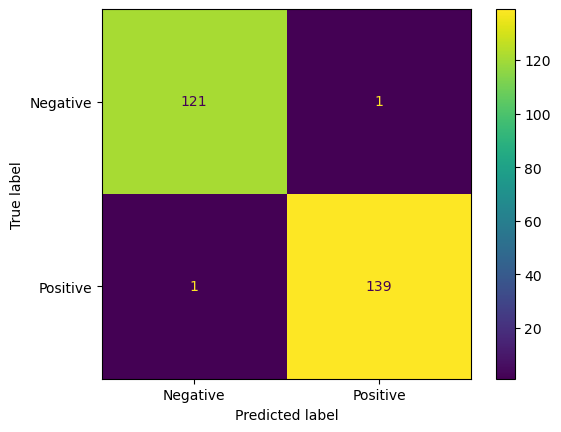

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       122
           1       0.99      0.99      0.99       140

    accuracy                           0.99       262
   macro avg       0.99      0.99      0.99       262
weighted avg       0.99      0.99      0.99       262



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Sample arrays for predicted and actual values

# Create the confusion matrix
cm = confusion_matrix(actual, predictions)

# Calculate total predictions
total_predictions = cm.sum()

# Get individual cell percentages
percentages = (cm / total_predictions) * 100

# Print the confusion matrix with percentages
print("Confusion Matrix (percentages):\n", percentages)

# Calculate total right and wrong predictions
correct_predictions = sum(np.diagonal(cm))
wrong_predictions = total_predictions - correct_predictions

# Print percentages of right and wrong predictions
print(f"Percent Right Predictions: {correct_predictions / total_predictions * 100:.2f}%\n")
print(f"Percent Wrong Predictions: {wrong_predictions / total_predictions * 100:.2f}%\n")

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

# Generate a classification report for additional details
print(classification_report(actual, predictions))